<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>

##### Applied AI Internal Project
# Daft PGM Demo
_Autumn 2016_

Barebones repo to demonstrate usage of `daft-pgm`, a small package for drawing plate notation diagrams purely in Python. The package is developed by [Dan Foreman-Mackey](http://dan.iel.fm), and there's lots of info and some demos at the project website [http://daft-pgm.org](http://daft-pgm.org)

>_As per the project_: Daft is a Python package that uses `matplotlib` to render pixel-perfect probabilistic graphical models for publication in a journal or on the internet. With a short Python script and an intuitive model building syntax you can design directed (Bayesian Networks, directed acyclic graphs) and undirected (Markov random fields) models and save them in any formats that `matplotlib` supports (including PDF, PNG, EPS and SVG).


This repo accompanies a larger project called [pymc3_vs_pystan](https://github.com/jonsedar/pymc3_vs_pystan) by Jonathan Sedar of Applied AI Ltd, which was written primarily for presentation at the [PyData London 2016 Conference](http://london.pydata.org).

Applied AI Ltd &copy; 2016

---

    
# 00_DaftPGMDemo


The following sections demonstrate drawing plate notation diagrams for a set of linear models which become progressively more complicated - adding new parameters and hierarchical features.


+ [Setup and Data Description](#Setup-and-Data-Description)


+ [Pooled Model](#Pooled-Model)


+ [Unpooled Model](#Unpooled-Model)


+ [Partial-Pooled Model](#Partial-Pooled-Model)


+ [Two-Level Hierarchical Model](#Two-Level-Hierarchical-Model)

# Setup and Data Description

In [1]:
%matplotlib inline
%qtconsole --colors=linux  
%load_ext watermark
# %connect_info

In [11]:
import matplotlib.pyplot as plt
from matplotlib import rc
import daft

# filter warnings for presentation's sake
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = 14, 8
rc("font", family="serif", size=12)
rc("text", usetex=False)

%watermark -dmvgp numpy,pandas,matplotlib,daft

2016-09-05 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
daft 0.0.4

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 14.5.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : HEAD


## Data Description

There is no dataset used in this Notebook, but frequent references are made to the _shape_ of the data. That data comes from a larger project called [pymc3_vs_pystan](https://github.com/jonsedar/pymc3_vs_pystan) by Jonathan Sedar of Applied AI Ltd, which was written primarily for presentation at the [PyData London 2016 Conference](http://london.pydata.org).

The dataset is [Car Fuel and Emissions Information](http://carfueldata.direct.gov.uk/) for August 2015 sourced from the [UK VCA Dept](http://www.dft.gov.uk/vca/) (Vehicle Type Approval), available for [direct download](http://carfueldata.direct.gov.uk/downloads/download.aspx?rg=aug2015).

The dataset contains information about fuel usage and engine emissions for roughly 2500 cars. Those cars have an inherent hierarchy:

parent (e.g. Volkswagen Group)   
$\;\;\;\;\;\;|\_\_ $ manufacturer (e.g. Audi)  
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;|\_\_ $ model (e.g. Audi A4)

... which we can incorporate into our modelling in order to more precisely evaluate car emissions.

The basic task then, becomes creating a linear regression to predict a car emissions measure, given a set of exogneous features of the car model (and it's hierarchical manufacturer structure).

That's all you really need to know for this Notebook, for more detail see the [pymc3_vs_pystan](https://github.com/jonsedar/pymc3_vs_pystan) repo. 

---

---

# Pooled Model

The simplest linear model:

$$y_{i} \sim \mathcal{N}(\beta^{T} \mathbf{x}_{i},\epsilon)$$

where:  
+ $y_{i} \sim \mathcal{Normal}$ is the observed real value for item, $i$  
+ $\mathbf{x}_{i}$ is a vector of descriptive features for each item, $i$  
+ $\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ is random noise in the measurement
+ $\beta$ are our pooled (shared) coeffs in the linear model  

##### First, create the Daft PGM base object

In [61]:
# declare the shape and size, and various styling
pgm = daft.PGM(shape=[2.5, 3.5], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')

##### Next, add nodes for the inside plate

In [62]:
# observed data
pgm.add_node(daft.Node("y", r"$y_i$", 1, 1.4, scale=2, observed=True))
pgm.add_node(daft.Node("x", r"$\mathbf{x}_{i}$", 1, 0.8, scale=2, 
                       fixed=True, offset=(0,-30)))

In [63]:
# individual items plate
pgm.add_plate(daft.Plate([0.5, 0.5, 1, 1.4], label=r"$i \in 1:N$", 
                         shift=-0.1))

##### Next, add nodes for the level upwards, here they have no plate because they are shared

In [64]:
# pooled beta (latent parameters)
pgm.add_node(daft.Node("beta", r"$\beta$", 1, 2.4, scale=2))
pgm.add_node(daft.Node("beta_mu", r"$\mu$", 0.8, 3, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_node(daft.Node("beta_sd", r"$\sigma^{2}$", 1.2, 3, scale=2,
                       fixed=True, offset=(0,6)))

In [65]:
# pooled measurement error
pgm.add_node(daft.Node("epsilon", r"$\epsilon$", 2, 1.4, scale=2))

##### Finally, draw the directed edges

In [66]:
# draw directed edges
pgm.add_edge("beta_mu", "beta")
pgm.add_edge("beta_sd", "beta")
pgm.add_edge("beta", "y")
pgm.add_edge("x", "y")
pgm.add_edge("epsilon", "y")

##### And render

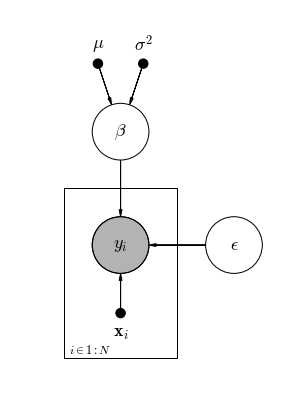

In [67]:
pgm.render()
plt.show()

**Observe:**

Here's our linear model in full:

+ $y_{i}$ is shaded, to indicate that it is an observed value
+ $\mathbf{x}_{i}$ is a fixed value. We can choose to show it for completeness
+ Both $y_{i}$ and $\mathbf{x}_{i}$ are contained within a _plate_ to indicate that their values can be different for each item $i \in 1:N$ in the dataset
+ $\epsilon$ is a single value shared by all items $i$, so it is located outside the _plate_
+ $\beta$ is also single value shared by all items $i$, so it is located outside the _plate_
    + $\mu$ and $\sigma^{2}$ are both fixed hyperparameters of the $\beta$ parameter describing its _mean_ and _standard deviation_
   

**Discussion:**
    
Plate notation has become something of a standard method for describing models, particularly in the discipline of machine learning. It offers a compact visual representation of model structure, makes it very easy to see the differences between models, and very importantly, encourages good notation practice.

However, plate notation is not perfect: it can be hard to indicate the sequence of a complicated algorithm, it is messy to show large numbers of non-shared parameters, and there is still plenty of room for authors to be lazy about notation. For more discussion see this dedicated (and opinionated) blogpost by [Rob Zinokow](http://www.zinkov.com/posts/2013-07-28-stop-using-plates/index.html).

Possibly the biggest issue with plate notation is the lack of facility to show which distributions are used for each parameter. In the above example, we don't actually see that both $y_{i}$ and $\beta$ are chosen from $Normal$ distributions, and that $\epsilon$ is chosen from a $HalfCauchy$ distribution. This doesn't completely ruin the representation of the model, and indeed selecting the appropriate distributions for a model is something of an art, but it does impact the reproducability of the documentation, and requires that we also spell out the model mathematically - somewhat negating the compact representation of plate notation.

One great remedy is that chosen by John Krushke, author of the brilliant practical guide [Doing Bayesian Data Analysis](https://sites.google.com/site/doingbayesiandataanalysis/) (a.k.a "the Dogs Book"). He has pioneered a notation style now known as "Krushke Diagrams" which show the parameter distributions, stochatistic & determinstic relations, and whether values are constant, variable, or parameters. [See this blogpost for worked examples and illustration software](http://doingbayesiandataanalysis.blogspot.co.uk/2013/10/diagrams-for-hierarchical-models-new.html).

> That said, let's press on with plate notation using `daft-pgm` and see what we can do.

---

---

# Unpooled Model

Here we allow each manufacturer (`mfr`) level to have a separate "unpooled" intercept. This would let us infer some difference between the cars according to their manufacturer.

$$y_{i} \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \mathbf{x}_{i},\epsilon)$$

where:  
+ $y_{i} \sim \mathcal{Normal}$ is the observed real value for item, $i$  
+ $\mathbf{x}_{i}$ is a vector of descriptive features for each item, $i$  
+ $\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ is random noise in the measurement
+ $\beta$ are our pooled coeffs in the linear model  

and:  
+ $\beta_{mfr} \sim \mathcal{N}(\mu_{mfr}, \sigma^{2}_{mfr})$ is a separate (unpooled) intercept for each manufacturer  
$\;\;\;\;\;\;\;\;\;\;\;\;|\_\_ \mu_{mfr} \sim \mathcal{N}(0, 100) \;\;;\;\;
\sigma^{2}_{mfr} \sim \mathcal{HalfCauchy}(0, 10)$ 




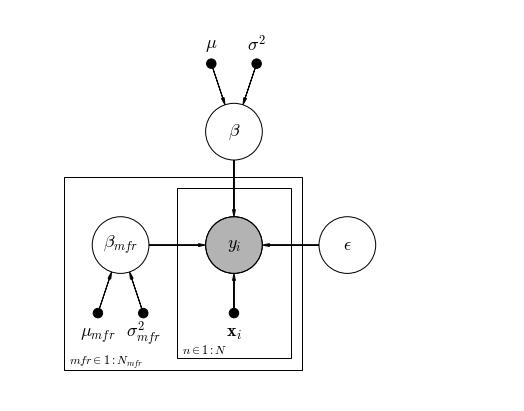

In [88]:
# create the basic daft-pgm layout, shape, size, and various styling
pgm = daft.PGM(shape=[4.5, 3.5], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')

# observed data
pgm.add_node(daft.Node("y", r"$y_i$", 2, 1.4, scale=2, observed=True))
pgm.add_node(daft.Node("x", r"$\mathbf{x}_{i}$", 2, 0.8, 
                       scale=2, fixed=True, offset=(0,-30)))

# individual item plate
pgm.add_plate(daft.Plate([1.5, 0.5, 1, 1.4], label=r"$n \in 1:N$", 
                         shift=-0.1))

# mfr parameters
pgm.add_node(daft.Node("beta_mfr", r"$\beta_{mfr}$", 1, 1.4, scale=2))
pgm.add_node(daft.Node("beta_mfr_mu", r"$\mu_{mfr}$", 0.8, 0.8, scale=2,
                       fixed=True, offset=(0,-30)))
pgm.add_node(daft.Node("beta_mfr_sd", r"$\sigma^{2}_{mfr}$", 1.2, 0.8, 
                       scale=2, fixed=True, offset=(0,-30)))

# mfr plate 
pgm.add_plate(daft.Plate([0.5, 0.4, 2.1, 1.6], 
                         label=r"$mfr \in 1:N_{mfr}$", shift=-0.1))

# pooled beta
pgm.add_node(daft.Node("beta", r"$\beta$", 2, 2.4, scale=2))
pgm.add_node(daft.Node("beta_mu", r"$\mu$", 1.8, 3, scale=2,
                       fixed=True, offset=(0,10)))
pgm.add_node(daft.Node("beta_sd", r"$\sigma^{2}$", 2.2, 3, scale=2,
                       fixed=True, offset=(0,6)))

# pooled measurement error
pgm.add_node(daft.Node("epsilon", r"$\epsilon$", 3, 1.4, scale=2))


# draw directed edges
pgm.add_edge("beta_mfr_mu", "beta_mfr")
pgm.add_edge("beta_mfr_sd", "beta_mfr")
pgm.add_edge("beta_mfr", "y")
pgm.add_edge("beta_mu", "beta")
pgm.add_edge("beta_sd", "beta")
pgm.add_edge("beta", "y")
pgm.add_edge("x", "y")
pgm.add_edge("epsilon", "y")

# render
pgm.render()
plt.show()

**Observe:**

This is largely the same as the pooled model, except for new additions:

+ $\beta_{mfr}$ is a single value pooled at the `mfr` level, so it is located outside the _item plate_, but inside a plate of it's own for $mfr \in 1:N_{mfr}$
    + $\mu$ and $\sigma^{2}$ are both hyperparameters of the $\beta_mfr$ parameter describing its _mean_ and _standard deviation_
    + Importantly, $\mu$ and $\sigma^{2}$ are inside the _mfr plate_ indicating that they too, vary per `mfr` level, and are "unpooled"
   

**Discussion:**

+ It's starting to get a bit messy. 
+ `daft-pgm` is handling this just fine, but there's a lot of ink on the page and if the model became any more complicated, it might become unhelpful.

> From here on, we'll simplify the diagram by excluding the fixed variables if they are on the same plate as their child.

---

---

# Partially-Pooled Model

Here we place partial-pooling on intercept only: this hyperparameter lets us - in a balanced way - determine a difference between manufacturers `mfr` $m \in manufacturer$, keeping all other features constant

$$y_{i} \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \mathbf{x}_{i},\epsilon)$$

where:  
+ $y_{i} \sim \mathcal{Normal}$ is the observed real value for item, $i$  
+ $\mathbf{x}_{i}$ is a vector of descriptive features for each item, $i$  
+ $\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ is random noise in the measurement
+ $\beta$ are our pooled coeffs in the linear model  

and:  
+ $\beta_{mfr} \sim \mathcal{N}(\mu, \sigma^{2})$ is a separate unpooled intercept for each manufacturer with pooled hyperparameters 
$\;\;\;\;\;\;\;\;\;\;\;\;|\_\_ \mu \sim \mathcal{N}(0, 100) \;\;;\;\;
\sigma^{2} \sim \mathcal{HalfCauchy}(0, 10)$ 

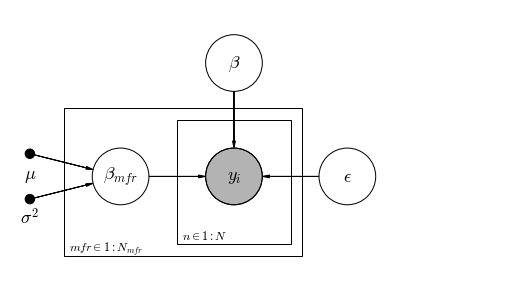

In [105]:
# create the basic daft-pgm layout, shape, size, and various styling
pgm = daft.PGM(shape=[4.5, 2.5], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')

# observed data
pgm.add_node(daft.Node("y", r"$y_i$", 2, 1, scale=2, observed=True))

# individual item plate
pgm.add_plate(daft.Plate([1.5, 0.5, 1, 1], label=r"$n \in 1:N$", 
                         shift=-0.1))

# mfr parameters
pgm.add_node(daft.Node("beta_mfr", r"$\beta_{mfr}$", 1, 1, scale=2))
pgm.add_node(daft.Node("beta_mfr_mu", r"$\mu$", 0.2, 1.2, scale=2, 
                       fixed=True, offset=(0,-30)))
pgm.add_node(daft.Node("beta_mfr_sd", r"$\sigma^{2}$", 0.2, 0.8, 
                       scale=2, fixed=True, offset=(0,-30)))

# mfr plate
pgm.add_plate(daft.Plate([0.5, 0.4, 2.1, 1.2], 
                         label=r"$mfr \in 1:N_{mfr}$", shift=-0.1))

# pooled beta
pgm.add_node(daft.Node("beta", r"$\beta$", 2, 2, scale=2))

# pooled measurement error
pgm.add_node(daft.Node("epsilon", r"$\epsilon$", 3, 1, scale=2))


# draw directed edges
pgm.add_edge("beta_mfr_mu", "beta_mfr")
pgm.add_edge("beta_mfr_sd", "beta_mfr")
pgm.add_edge("beta_mfr", "y")
pgm.add_edge("beta", "y")
pgm.add_edge("epsilon", "y")

# render
pgm.render()
plt.show()

**Observe:**

+ This diagram is simpler than that for the unpooled model, we have removed the fixed nodes that are on the same plate as their children: $\mathbf{x}_i$, and the $\mu$ and $\sigma^{2}$ hyperparamters for $\beta$.
+ We also easily see the _partial pooling_ on $\beta_{mfr}$, wherein the $\beta_{mfr}$ distribution is unpooled (allowed to vary per `mfr` level), but its hyperparameters $\mu$ and $\sigma^{2}$ are pooled.

**Discussion:**

+ By removing the fixed nodes at the same level as their children, we gain clarity without much loss of comprehension
+ The nested nature of the partial pooling is also now more clear

> Let's continue the nesting to another level of hierarchy

---

---

# Two-level Hierarchical Model

Each manufacturer is really just a brand-marque of a larger parent company which may own several brands. It's quite possible that a group of manufacturers under a parent group could be affected by the parent and thereby pool or "share" information.

We restate the linear model:

$$y_{i} \sim \mathcal{N}(\beta_{mfr} + \beta^{T} \mathbf{x}_{i},\epsilon)$$

where:  
+ $y_{i} \sim \mathcal{Normal}$ is the observed real value for item, $i$  
+ $\mathbf{x}_{i}$ is a vector of descriptive features for each item, $i$  
+ $\epsilon \sim \mathcal{HalfCauchy}(0, 10)$ is random noise in the measurement
+ $\beta$ are our pooled coeffs in the linear model  

and:  
+ $\beta_{mfr} \sim \mathcal{N}(\mu_{parent}, \sigma^{2})$ is a separate partial-pooled intercept for each `mfr` with hyperparameters that depend upon the `parent`, which itself is partial-pooled
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;|\_\_ \mu_{parent} \sim \mathcal{N}(\mu, \sigma^{2}) \;\;;\;\;
\sigma^{2} \sim \mathcal{HalfCauchy}(0, 10)$ 
$\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;|\_\_  \mu \sim \mathcal{N}(0, 10) \;\; ; \;\; \sigma^{2}\sim \mathcal{HalfCauchy}(0, 10)$  





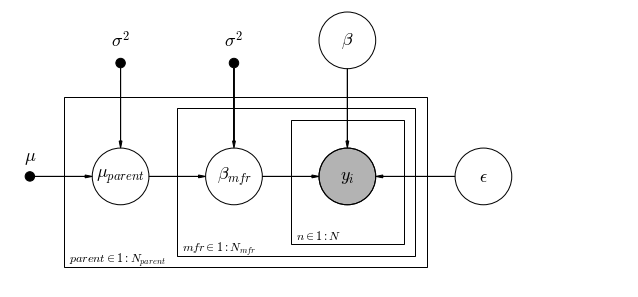

In [123]:
# create the basic daft-pgm layout, shape, size, and various styling
pgm = daft.PGM(shape=[5.5, 2.5], origin=[0, 0], grid_unit=4,
               label_params={'fontsize':18}, observed_style='shaded')

# observed data
pgm.add_node(daft.Node("y", r"$y_i$", 3, 1, scale=2, observed=True))

# individual item plate
pgm.add_plate(daft.Plate([2.5, 0.5, 1, 1], label=r"$n \in 1:N$", 
                         shift=-0.1))

# mfr parameters
pgm.add_node(daft.Node("beta_mfr", r"$\beta_{mfr}$", 2, 1, scale=2))
pgm.add_node(daft.Node("beta_mfr_mu", r"$\mu_{parent}$", 1, 1, scale=2))
pgm.add_node(daft.Node("beta_mfr_sd", r"$\sigma^{2}$", 2, 2, scale=2, 
                       fixed=True, offset=(0,10)))

# mfr plate
pgm.add_plate(daft.Plate([1.5, 0.4, 2.1, 1.2], 
                         label=r"$mfr \in 1:N_{mfr}$", shift=-0.1))

# parent hyperparameters
pgm.add_node(daft.Node("parent_mu", r"$\mu$", 0.2, 1, scale=2, 
                       fixed=True, offset=(0,10)))
pgm.add_node(daft.Node("parent_sd", r"$\sigma^{2}$", 1, 2, scale=2, 
                       fixed=True, offset=(0,10)))

# parent plate
pgm.add_plate(daft.Plate([0.5, 0.3, 3.2, 1.4], 
                         label=r"$parent \in 1:N_{parent}$", shift=-0.1))

# pooled beta
pgm.add_node(daft.Node("beta", r"$\beta$", 3, 2.2, scale=2))

# pooled measurement error
pgm.add_node(daft.Node("epsilon", r"$\epsilon$", 4.2, 1, scale=2))


# draw directed edges
pgm.add_edge("parent_mu", "beta_mfr_mu")
pgm.add_edge("parent_sd", "beta_mfr_mu")
pgm.add_edge("beta_mfr_mu", "beta_mfr")
pgm.add_edge("beta_mfr_sd", "beta_mfr")
pgm.add_edge("beta_mfr", "y")
pgm.add_edge("beta", "y")
pgm.add_edge("epsilon", "y")

# render
pgm.render()
plt.show()

**Observe:**

+ The nested hierarchy becomes really clear using this plate notation, and it becomes very simple to compare to the previous partial-pooled, unpooled and pooled models
+ The arrows (directed graph) really comes into play too, as it shows us the flow of the algorithm and helps to clarify the precise notation of the $\mu$ and $\sigma^{2}$ hyperparameters

**Discussion:**

+ The above diagrams show a reasoned progression from a basic pooled linear model right up to a two-level nested hierarchical linear model.
+ Plate notation is a very useful addition to mathematical notation, and `daft-pgm` makes it fairly straightforward to construct these diagrams entirely in Python, using a simple API based on the familiar `matplotlib` package.
+ Finally, even with this most complicated hierarchical model, the code required to control the `daft-pgm` diagram is not too onerous, and can be easily broken into a separate class / file if desired.

---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>